<a href="https://colab.research.google.com/github/shubhu1026/AI-ML/blob/main/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div style="text-align: left; background-color:black; font-family: Trebuchet MS; color:#A60505; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: black solid;"> **BERT-Based Chatbot with Exploratory Data Analysis** </div>

In [ ]:
from google.colab import files
files.upload()  # Choose the kaggle.json file from your local machine

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shubhu1026","key":"eb70f1e9edf543dcd554e773be864e4d"}'}

In [ ]:
import shutil
import os

# Create the .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the uploaded file to the correct location
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set correct permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

In [ ]:
# Now download the dataset
!kaggle datasets download -d icw123/glove-twitter
!kaggle datasets download -d niraliivaghani/chatbot-dataset

Dataset URL: https://www.kaggle.com/datasets/icw123/glove-twitter
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/niraliivaghani/chatbot-dataset
License(s): DbCL-1.0


In [ ]:
# Unzip it
!unzip -q glove-twitter
!unzip -q chatbot-dataset

<a id="1"></a>
## <b>1. <span style='color:#B21010'></span> Introduction</b>


<div style="border-radius:10px;
            border: black solid;
            adding: 15px;
            background-color:#FBA7A7;
            font-size:120%;
            text-aling: left">
<h3 style:'border:0; border-radius: 15px; color: black'><center> How we will build the Chatbot?:</center></h3>

_________________________________________________________________________
    
Chatbots are AI-powered programs that simulate human conversation. They can answer questions, perform tasks, and engage with users, making technology more accessible and efficient.
we will walk through this steps:
    
1. Load the data<br>
2. EDA and analyze the data for more insights
3. Split the data into train, test and validation datasets<br>
4. Load BERT Pretrained model and tokenizer<br>
5. Transform the data to numerical format<br>
6. Train BERT Pretrained model on our custome dataset<br>
7. Evaluate the model <br>
8. Save the model<br>
9. Finally, Load The model and start the conversation

<a id="2"></a>
## <b>2. <span style='color:#B21010'></span> Import Necessaries</b>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras.layers import TextVectorization
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

<a id="3"></a>
## <b>3. <span style='color:#B21010'></span> EDA + Vis</b>

<a id="3.1"></a>
### <b>3.1 <span style='color:#B21010'></span> Load the data</b>

In [ ]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/intents.json'

intents = load_json_file(filename)

<a id="3.2"></a>
### <b>3.2 <span style='color:#B21010'></span> Extract Info from the Json data file and Store it in dataframe</b>

In [ ]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [ ]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [ ]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


<a id="3.3"></a>
### <b>3.3 <span style='color:#B21010'></span> Check the shape of the dataset</b>

In [ ]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 405 rows and 2 columns


<a id="3.4"></a>
### <b>3.4 <span style='color:#B21010'></span> Display information about the dataset</b>

In [ ]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
None


<a id="3.5"></a>
### <b>3.5 <span style='color:#B21010'></span> Display Number of Classes</b>

In [ ]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 38 classes


<a id="3.6"></a>
### <b>3.6 <span style='color:#B21010'></span> Check the null values in the dataset</b>

In [ ]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


<a id="3.7"></a>
### <b>3.7 <span style='color:#B21010'></span> Visualize the Null Values</b>

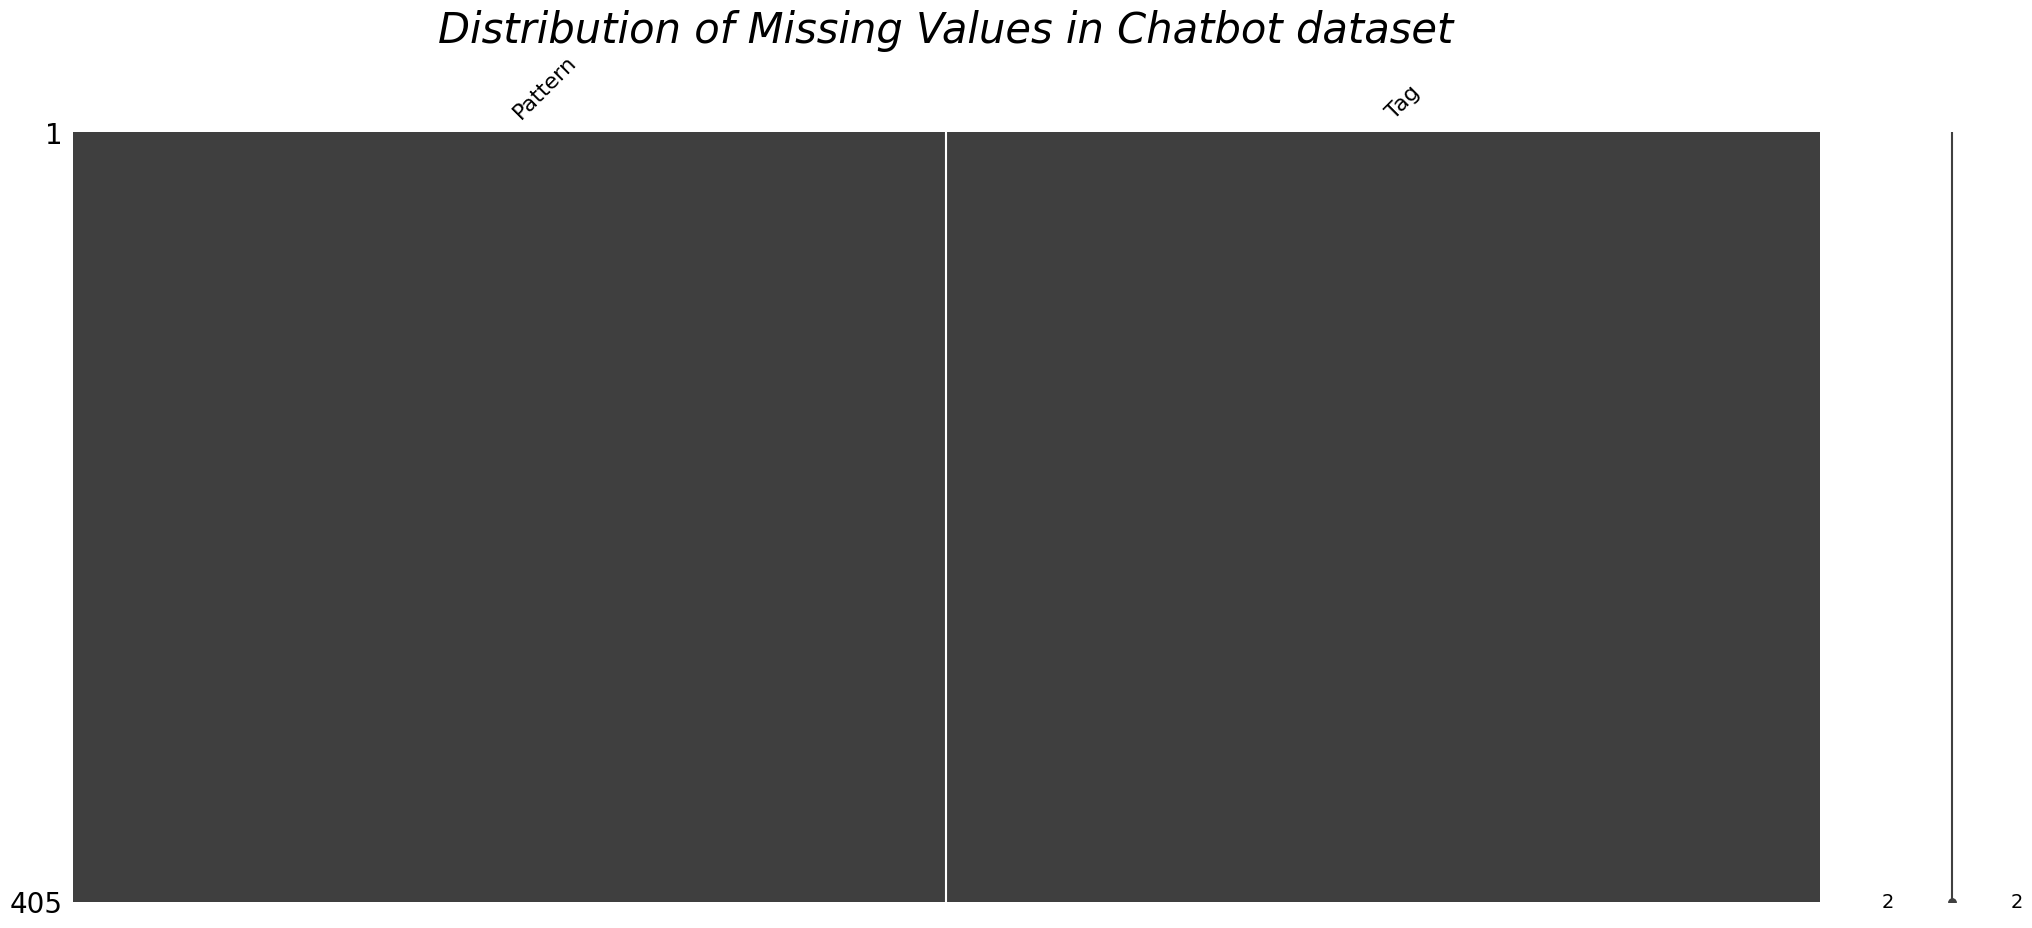

In [ ]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

<a id="3.8"></a>
### <b>3.8 <span style='color:#B21010'></span> Visualize the distrbution of our Classes</b>

In [ ]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

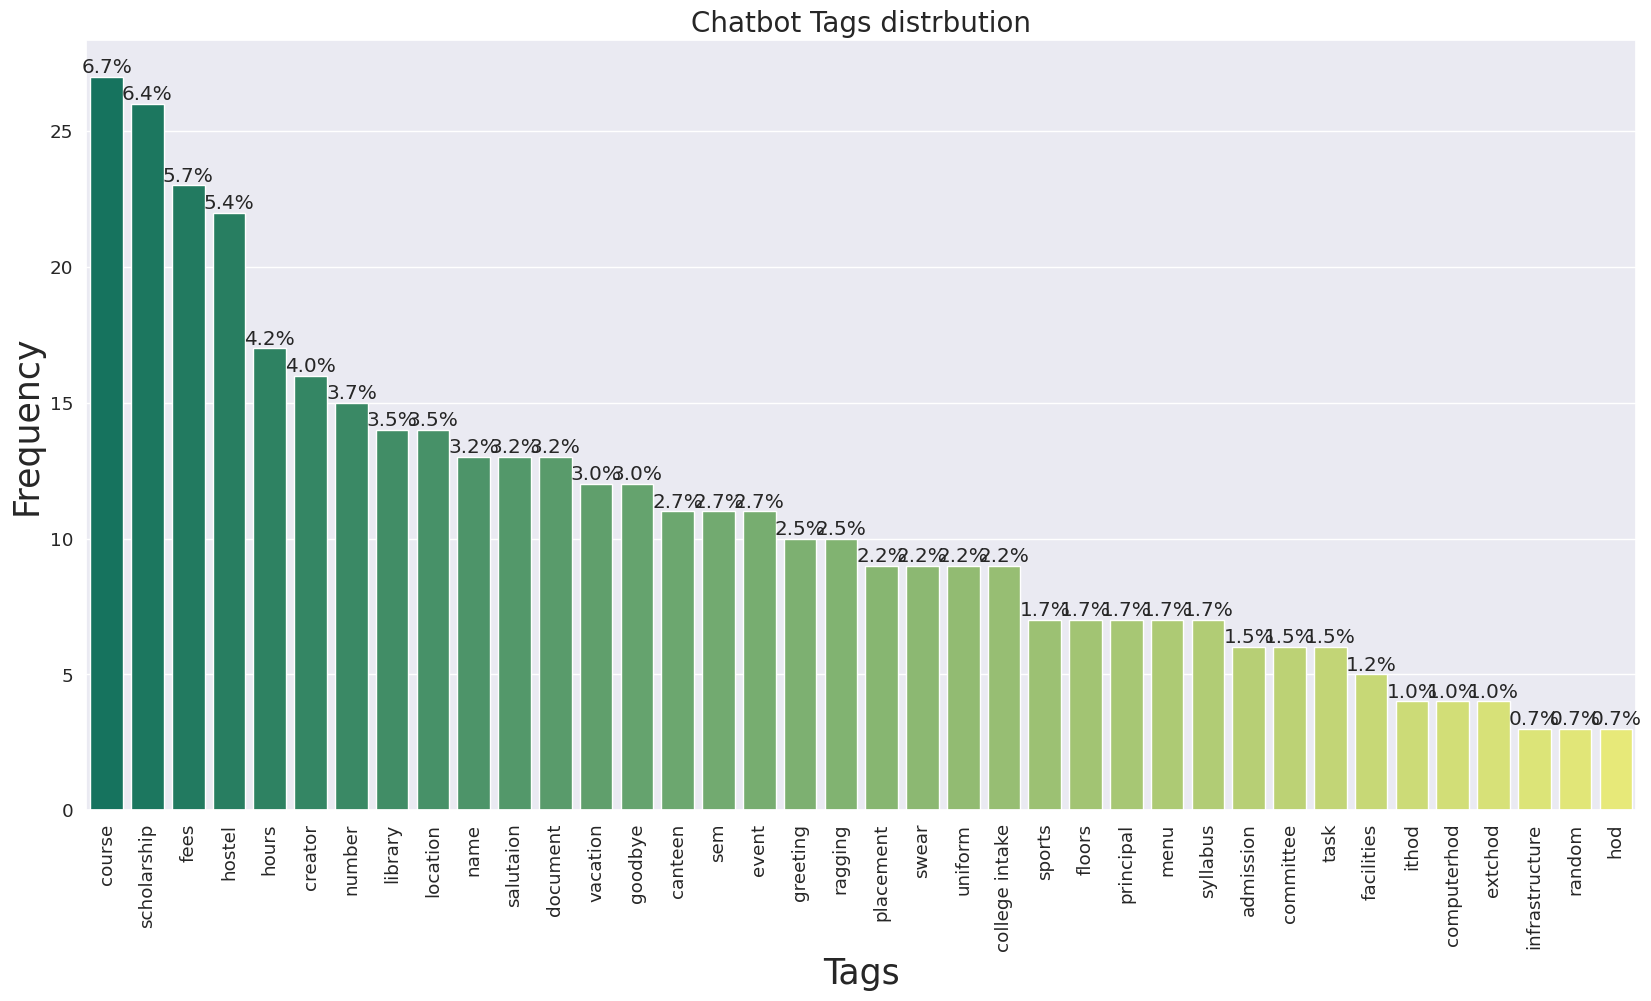

In [ ]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [ ]:
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


In [ ]:
print(df['Pattern'].isnull().sum())

0


<a id="3.9"></a>
### <b>3.9 <span style='color:#B21010'></span> Display Word Cloud</b>

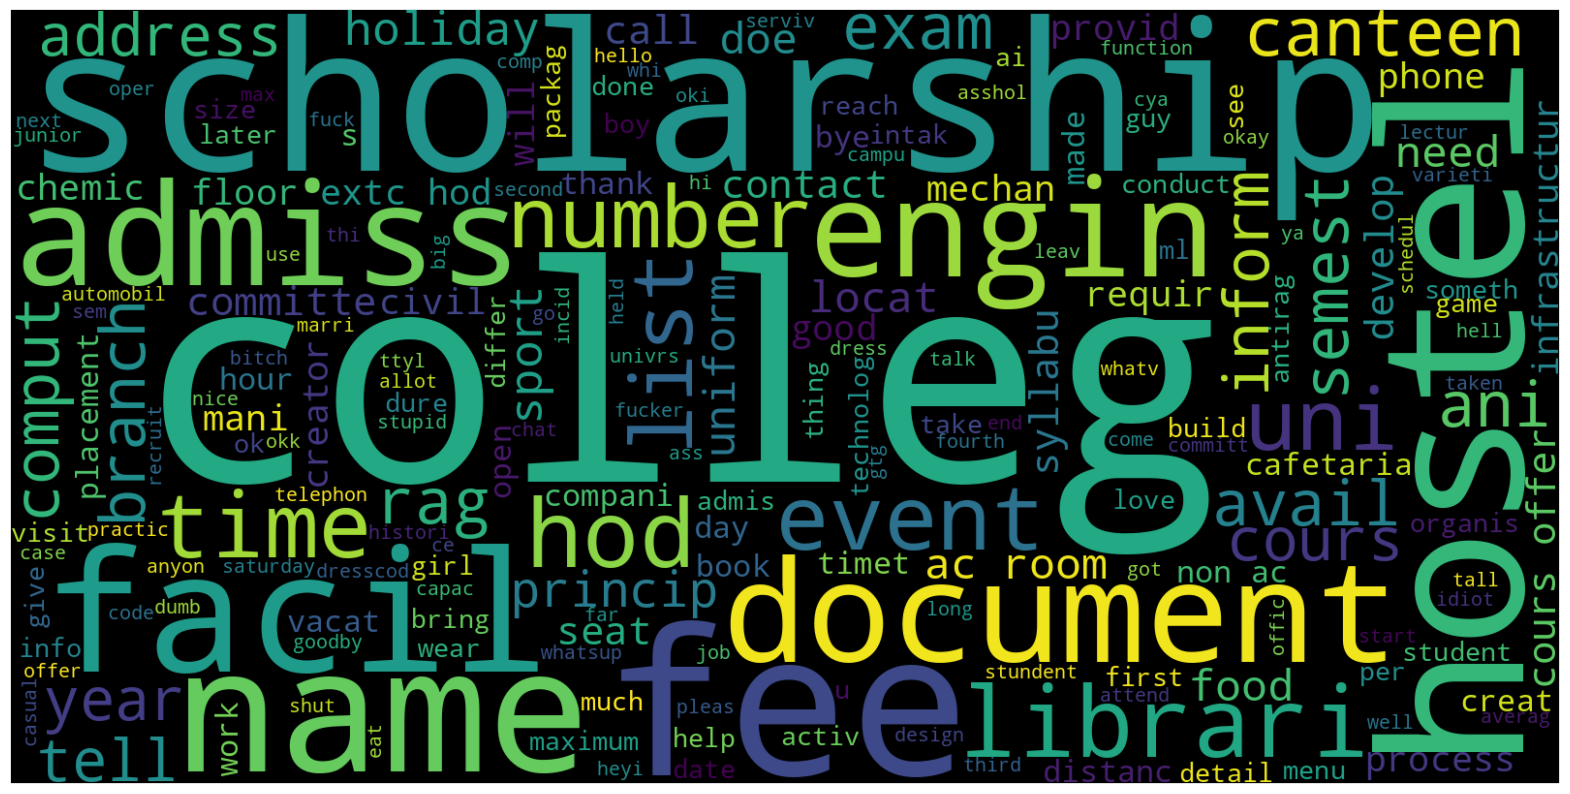

In [ ]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

<a id="3.10"></a>
### <b>3.10 <span style='color:#B21010'></span> Distrbution of Number of letters in each text</b>

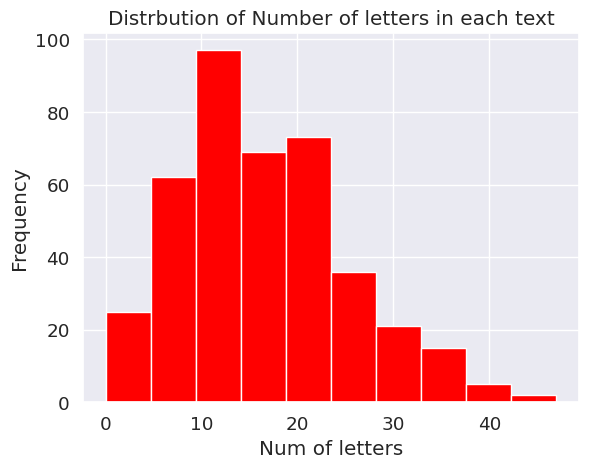

In [ ]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

<a id="3.11"></a>
### <b>3.11 <span style='color:#B21010'></span> Distrbution of Number of words in each text</b>

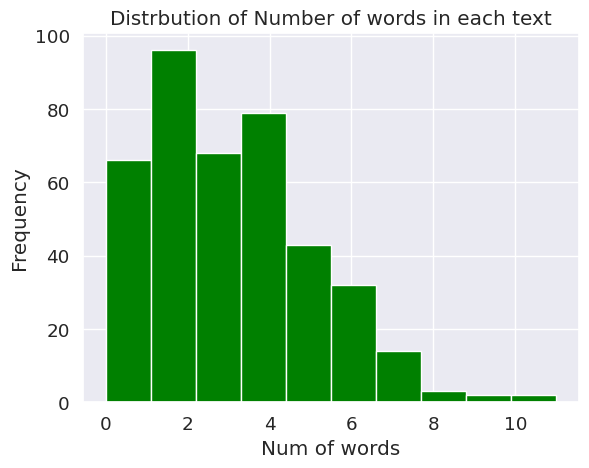

In [ ]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

<a id="3.12"></a>
### <b>3.12 <span style='color:#B21010'></span> Visualize Average word length in each text</b>

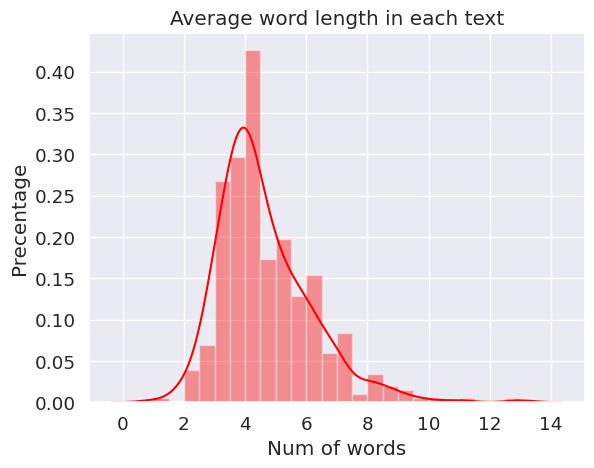

In [ ]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

<a id="3.13"></a>
### <b>3.13 <span style='color:#B21010'></span> Visualize top words</b>

In [ ]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hi', 'how', 'are', 'you', 'is']

In [ ]:
print(f"dataset contains {len(corpus)} words")

dataset contains 1345 words


In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'is': 75,
 'colleg': 71,
 'what': 59,
 'the': 46,
 'you': 35,
 'of': 33,
 'in': 29,
 'for': 26,
 'scholarship': 26,
 'are': 25}

In [ ]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

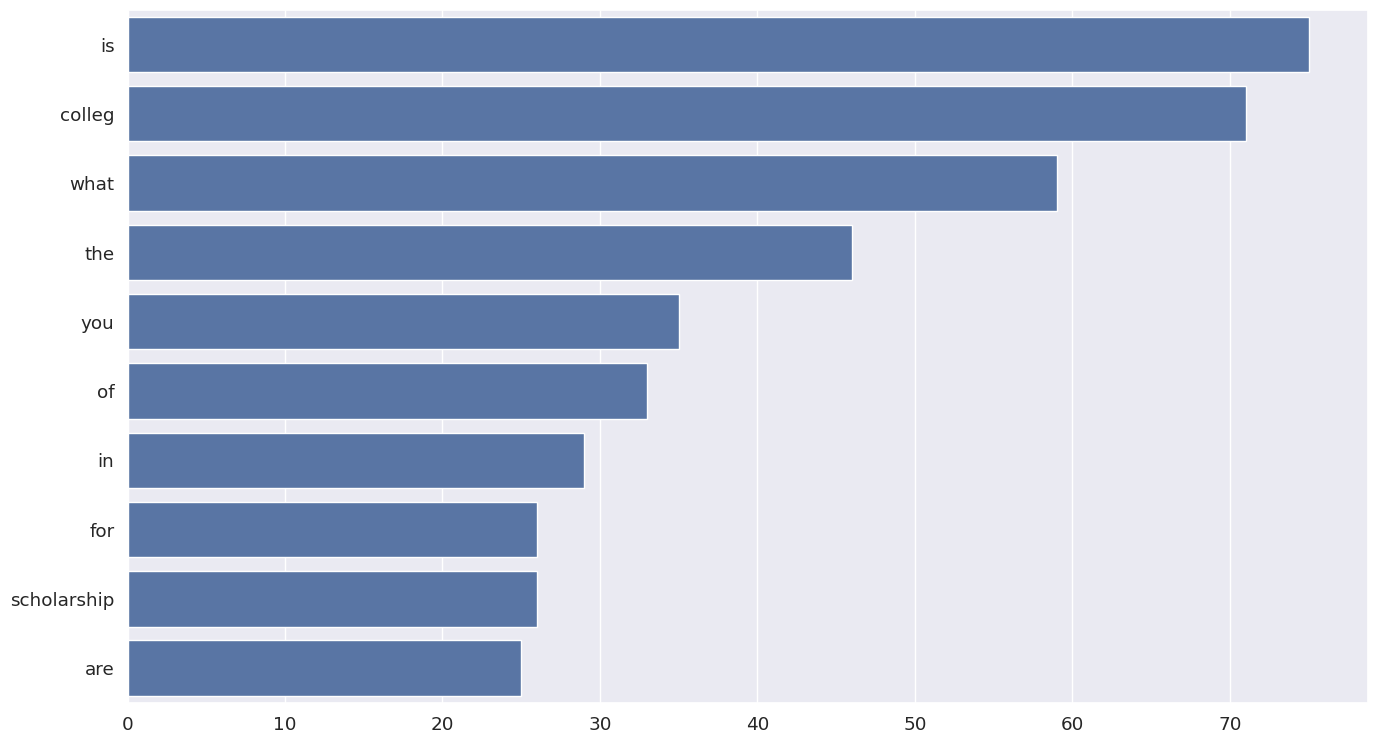

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

<a id="4"></a>
## <b>4. <span style='color:#B21010'></span> Data Preprocessing</b>

In [ ]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [ ]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [ ]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [ ]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod'}

In [ ]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37}

In [ ]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


<a id="5"></a>
## <b>5. <span style='color:#B21010'></span> Split the data into train and test</b>

In [ ]:
X = list(df2['Pattern'])
X[:5]

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']

In [ ]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

<a id="6"></a>
## <b>6. <span style='color:#B21010'></span> Load BERT Pretrained model and Tokenizer</b>

In [ ]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<a id="7"></a>
## <b>7. <span style='color:#B21010'></span> Transform the data into numerical format</b>

In [ ]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
full_data = tokenizer(X, truncation=True, padding=True)

<a id="8"></a>
## <b>8. <span style='color:#B21010'></span> Build Data Loader</b>


In [ ]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

<a id="9"></a>
## <b>9. <span style='color:#B21010'></span> Define Evaluation Metrcies</b>


In [ ]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

<a id="10"></a>
## <b>10. <span style='color:#B21010'></span> Define Training Arguments</b>


In [ ]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

<a id="11"></a>
## <b>11. <span style='color:#B21010'></span> Train the model</b>


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kool619shubhu (kool619shubhu-individual) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.506300,3.304905,0.147059,0.070764,0.074483,0.117204
100,2.559500,2.107505,0.588235,0.504405,0.561024,0.544866
150,1.126900,0.912127,0.911765,0.918675,0.938172,0.932258
200,0.349900,0.586273,0.911765,0.912531,0.930108,0.932258
250,0.121100,0.504477,0.921569,0.919699,0.934946,0.940323
300,0.058200,0.471646,0.921569,0.919699,0.934946,0.940323
350,0.055500,0.510590,0.921569,0.919699,0.934946,0.940323
400,0.033100,0.481457,0.921569,0.901202,0.916146,0.912500
450,0.024900,0.493680,0.931373,0.934753,0.945699,0.948387
500,0.023100,0.480337,0.931373,0.934753,0.945699,0.948387


TrainOutput(global_step=1000, training_loss=0.40038034951686857, metrics={'train_runtime': 339.3163, 'train_samples_per_second': 89.297, 'train_steps_per_second': 2.947, 'total_flos': 264789670748400.0, 'train_loss': 0.40038034951686857, 'epoch': 100.0})

<a id="12"></a>
## <b>12. <span style='color:#B21010'></span> Evaluate the model</b>


In [ ]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.010220,0.996700,0.998528,0.998452,0.998684
test,0.506249,0.931373,0.934753,0.945699,0.948387


In [ ]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
text = "Hello"
predict(text)

(tensor([[9.9270e-01, 4.6522e-04, 5.3401e-05, 5.8393e-04, 7.3867e-05, 4.8904e-04,
          5.5325e-05, 5.7007e-05, 3.1223e-05, 2.4292e-04, 5.1238e-05, 1.2139e-05,
          4.6459e-04, 6.7355e-05, 5.2968e-05, 1.7753e-04, 6.7645e-04, 1.3235e-04,
          6.7284e-05, 4.8196e-05, 5.3288e-05, 2.4243e-04, 1.9343e-04, 9.4559e-05,
          5.8529e-05, 2.1850e-05, 2.3709e-05, 2.7000e-05, 4.5339e-04, 8.4296e-05,
          2.1496e-04, 2.5117e-04, 3.1119e-04, 9.8577e-05, 4.0660e-04, 7.8107e-04,
          2.8866e-05, 1.5290e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'greeting')

<a id="13"></a>
## <b>13. <span style='color:#B21010'></span> Save the model</b>


In [ ]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [ ]:
!pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

<a id="14"></a>
## <b>14. <span style='color:#B21010'></span> Load the model</b>


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast, pipeline

In [ ]:
model_path = "/content/chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [ ]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9927000403404236}]

In [ ]:
chatbot("Waht are college timings?")

[{'label': 'hours', 'score': 0.9961923360824585}]

In [ ]:
chatbot("Waht are college timings?")

<a id="15"></a>
## <b>15. <span style='color:#B21010'></span> Chat with the Chatbot</b>


In [ ]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()


In [ ]:
# c8cbb8f958a82e59968d97e023d23a17c04d8667

In [ ]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


Chatbot: Hi there, how can I help?


Chatbot: I am a Chatbot.


Chatbot: College is open 8am-5pm Monday-Saturday!


Chatbot: Our university offers Information Technology, computer Engineering, Mechanical engineering,Chemical engineering, Civil engineering and extc Engineering.




### Downloading Model

In [ ]:
!zip -r chatbot_model.zip /content/chatbot


  adding: content/chatbot/ (stored 0%)
  adding: content/chatbot/config.json (deflated 61%)
  adding: content/chatbot/tokenizer_config.json (deflated 75%)
  adding: content/chatbot/training_args.bin (deflated 52%)
  adding: content/chatbot/special_tokens_map.json (deflated 42%)
  adding: content/chatbot/model.safetensors (deflated 7%)
  adding: content/chatbot/vocab.txt (deflated 53%)


In [ ]:
from google.colab import files
files.download('chatbot_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>